<a href="https://www.kaggle.com/code/jairsouza/perfil-dos-prefeitos-no-brasil?scriptVersionId=231055866" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import warnings
from imblearn.over_sampling import SMOTE

# Carregamento da base de dados e transformação das váriaveis

In [2]:
warnings.filterwarnings("ignore") 

In [3]:
planinha = pd.ExcelFile("/kaggle/input/municipios-2021/Base_MUNIC_2021_20240425.xlsx")
planinha.sheet_names

['Dicionário',
 'Informações atual prefeito',
 'Recursos humanos',
 'Legislação e instr de planej',
 'Educação',
 'Cultura',
 'Esporte',
 'Saúde',
 'COVID',
 'Variáveis externas']

In [4]:
df = pd.read_excel("/kaggle/input/municipios-2021/Base_MUNIC_2021_20240425.xlsx", sheet_name="Informações atual prefeito")
df

,CodMun,UF,Cod UF,Mun,Pop estimada 2021,Faixa_pop,Regiao,Mpeg02,Mpeg03,Mpeg04,Mpeg05,Mpeg051,Mpeg06
0,1100015,RO,11,Alta Floresta DOeste,22516,4 - 20001 até 50000,1 - Norte,Não,Masculino,40,Branca,Sim,Especialização
1,1100023,RO,11,Ariquemes,111148,6 - 100001 até 500000,1 - Norte,Não,Feminino,33,Branca,Sim,Ensino superior completo
2,1100031,RO,11,Cabixi,5067,2 - 5001 até 10000,1 - Norte,Sim,Masculino,50,Parda,Não,Ensino superior completo
3,1100049,RO,11,Cacoal,86416,5 - 50001 até 100000,1 - Norte,Não,Masculino,35,Parda,Sim,Ensino superior completo
4,1100056,RO,11,Cerejeiras,16088,3 - 10001 até 20000,1 - Norte,Sim,Feminino,57,Branca,Não,Ensino superior completo
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5565,5222005,GO,52,Vianópolis,14088,3 - 10001 até 20000,5 - Centro-Oeste,Não,Masculino,38,Branca,Não,Ensino superior completo
5566,5222054,GO,52,Vicentinópolis,9002,2 - 5001 até 10000,5 - Centro-Oeste,Sim,Masculino,55,Branca,Não,Ensino médio (2º Grau) completo
5567,5222203,GO,52,Vila Boa,6451,2 - 5001 até 10000,5 - Centro-Oeste,Não,Masculino,49,Branca,Não,Ensino superior completo
5568,5222302,GO,52,Vila Propício,5941,2 - 5001 até 10000,5 - Centro-Oeste,Não,Masculino,49,Parda,Sim,Ensino superior completo


In [5]:
df.shape

(5570, 13)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5570 entries, 0 to 5569
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   CodMun             5570 non-null   int64 
 1   UF                 5570 non-null   object
 2   Cod UF             5570 non-null   int64 
 3   Mun                5570 non-null   object
 4   Pop estimada 2021  5570 non-null   int64 
 5   Faixa_pop          5570 non-null   object
 6   Regiao             5570 non-null   object
 7   Mpeg02             5570 non-null   object
 8   Mpeg03             5570 non-null   object
 9   Mpeg04             5570 non-null   object
 10  Mpeg05             5570 non-null   object
 11  Mpeg051            5570 non-null   object
 12  Mpeg06             5570 non-null   object
dtypes: int64(3), object(10)
memory usage: 565.8+ KB


In [7]:
colunas_remover = ["CodMun", "Cod UF", 'Pop estimada 2021', 'Mpeg051']
df = df.drop(colunas_remover, axis=1)
df

,UF,Mun,Faixa_pop,Regiao,Mpeg02,Mpeg03,Mpeg04,Mpeg05,Mpeg06
0,RO,Alta Floresta DOeste,4 - 20001 até 50000,1 - Norte,Não,Masculino,40,Branca,Especialização
1,RO,Ariquemes,6 - 100001 até 500000,1 - Norte,Não,Feminino,33,Branca,Ensino superior completo
2,RO,Cabixi,2 - 5001 até 10000,1 - Norte,Sim,Masculino,50,Parda,Ensino superior completo
3,RO,Cacoal,5 - 50001 até 100000,1 - Norte,Não,Masculino,35,Parda,Ensino superior completo
4,RO,Cerejeiras,3 - 10001 até 20000,1 - Norte,Sim,Feminino,57,Branca,Ensino superior completo
...,...,...,...,...,...,...,...,...,...
5565,GO,Vianópolis,3 - 10001 até 20000,5 - Centro-Oeste,Não,Masculino,38,Branca,Ensino superior completo
5566,GO,Vicentinópolis,2 - 5001 até 10000,5 - Centro-Oeste,Sim,Masculino,55,Branca,Ensino médio (2º Grau) completo
5567,GO,Vila Boa,2 - 5001 até 10000,5 - Centro-Oeste,Não,Masculino,49,Branca,Ensino superior completo
5568,GO,Vila Propício,2 - 5001 até 10000,5 - Centro-Oeste,Não,Masculino,49,Parda,Ensino superior completo


In [8]:
df.columns

Index(['UF', 'Mun', 'Faixa_pop', 'Regiao', 'Mpeg02', 'Mpeg03', 'Mpeg04',
       'Mpeg05', 'Mpeg06'],
      dtype='object')

In [9]:
df.dtypes

UF           object
Mun          object
Faixa_pop    object
Regiao       object
Mpeg02       object
Mpeg03       object
Mpeg04       object
Mpeg05       object
Mpeg06       object
dtype: object

In [10]:
df = df.rename(columns={"Mpeg02": "Reeleito", "Mpeg03":"Sexo", "Mpeg04":"Idade", "Mpeg05":"Cor", "Mpeg06": "Escolaridade"})
df 

,UF,Mun,Faixa_pop,Regiao,Reeleito,Sexo,Idade,Cor,Escolaridade
0,RO,Alta Floresta DOeste,4 - 20001 até 50000,1 - Norte,Não,Masculino,40,Branca,Especialização
1,RO,Ariquemes,6 - 100001 até 500000,1 - Norte,Não,Feminino,33,Branca,Ensino superior completo
2,RO,Cabixi,2 - 5001 até 10000,1 - Norte,Sim,Masculino,50,Parda,Ensino superior completo
3,RO,Cacoal,5 - 50001 até 100000,1 - Norte,Não,Masculino,35,Parda,Ensino superior completo
4,RO,Cerejeiras,3 - 10001 até 20000,1 - Norte,Sim,Feminino,57,Branca,Ensino superior completo
...,...,...,...,...,...,...,...,...,...
5565,GO,Vianópolis,3 - 10001 até 20000,5 - Centro-Oeste,Não,Masculino,38,Branca,Ensino superior completo
5566,GO,Vicentinópolis,2 - 5001 até 10000,5 - Centro-Oeste,Sim,Masculino,55,Branca,Ensino médio (2º Grau) completo
5567,GO,Vila Boa,2 - 5001 até 10000,5 - Centro-Oeste,Não,Masculino,49,Branca,Ensino superior completo
5568,GO,Vila Propício,2 - 5001 até 10000,5 - Centro-Oeste,Não,Masculino,49,Parda,Ensino superior completo


In [11]:
df["Mun"] = df["Mun"].astype("string")
df["Faixa_pop"] = df["Faixa_pop"].astype("category")
df["Regiao"] = df["Regiao"].astype("category")
df["UF"] = df["UF"].astype("category")
df["Reeleito"] = df["Reeleito"].astype("category")
df["Sexo"] = df["Sexo"].astype("category")
df["Cor"] = df["Cor"].astype("category")
df["Escolaridade"] = df["Escolaridade"].astype("category")

In [12]:
def tirar_texto(string):
    index = string.find("-") + 1
    return string[index:]

In [13]:
df["Faixa_pop"] = df["Faixa_pop"].apply(tirar_texto)
df["Regiao"] = df["Regiao"].apply(tirar_texto)
df

,UF,Mun,Faixa_pop,Regiao,Reeleito,Sexo,Idade,Cor,Escolaridade
0,RO,Alta Floresta DOeste,20001 até 50000,Norte,Não,Masculino,40,Branca,Especialização
1,RO,Ariquemes,100001 até 500000,Norte,Não,Feminino,33,Branca,Ensino superior completo
2,RO,Cabixi,5001 até 10000,Norte,Sim,Masculino,50,Parda,Ensino superior completo
3,RO,Cacoal,50001 até 100000,Norte,Não,Masculino,35,Parda,Ensino superior completo
4,RO,Cerejeiras,10001 até 20000,Norte,Sim,Feminino,57,Branca,Ensino superior completo
...,...,...,...,...,...,...,...,...,...
5565,GO,Vianópolis,10001 até 20000,Centro-Oeste,Não,Masculino,38,Branca,Ensino superior completo
5566,GO,Vicentinópolis,5001 até 10000,Centro-Oeste,Sim,Masculino,55,Branca,Ensino médio (2º Grau) completo
5567,GO,Vila Boa,5001 até 10000,Centro-Oeste,Não,Masculino,49,Branca,Ensino superior completo
5568,GO,Vila Propício,5001 até 10000,Centro-Oeste,Não,Masculino,49,Parda,Ensino superior completo


In [14]:
df['Escolaridade'].unique()

['Especialização', 'Ensino superior completo', 'Ensino médio (2º Grau) completo', 'Ensino superior incompleto', 'Doutorado', 'Ensino médio (2º Grau) incompleto', 'Ensino fundamental (1º Grau) incompleto', 'Ensino fundamental ( 1º Grau) completo', 'Mestrado', 'Recusa']
Categories (10, object): ['Doutorado', 'Ensino fundamental ( 1º Grau) completo', 'Ensino fundamental (1º Grau) incompleto', 'Ensino médio (2º Grau) completo', ..., 'Ensino superior incompleto', 'Especialização', 'Mestrado', 'Recusa']

In [15]:
df = df.replace("Não", "Nao")

In [16]:
df = df.replace({"Não informou": None, "Recusa": None})
df = df[df["Idade"].notna()]

In [17]:
df["Idade"] = df["Idade"].astype("int")

# Análise exploratória 

<Axes: xlabel='Reeleito'>

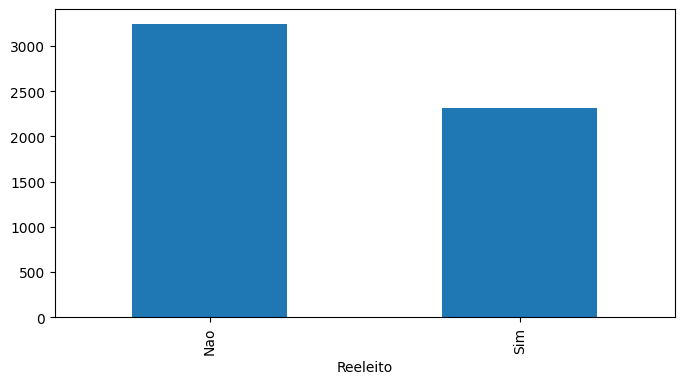

In [18]:
df.groupby("Reeleito", observed=False)['UF'].count().plot(kind='bar', figsize=(8,4))

<Axes: xlabel='Escolaridade'>

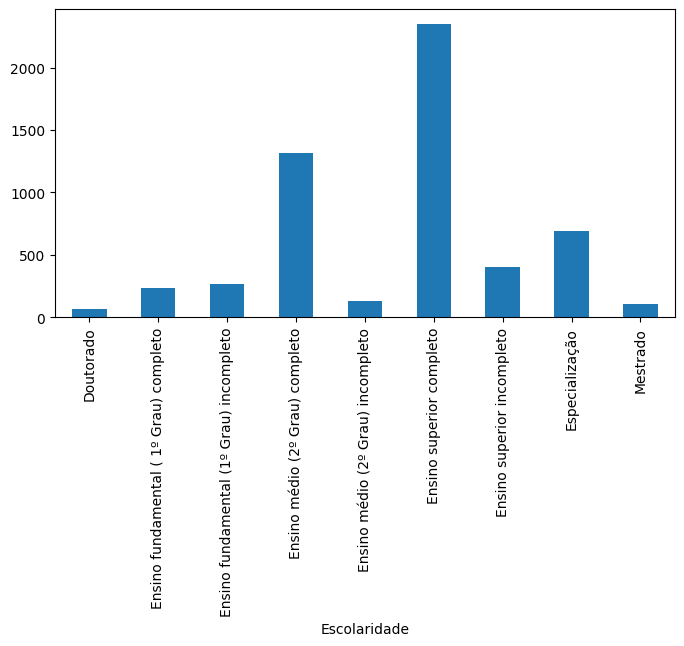

In [19]:
df.groupby("Escolaridade", observed=False)['UF'].count().plot(kind='bar', figsize=(8,4))

<Axes: xlabel='Faixa_pop'>

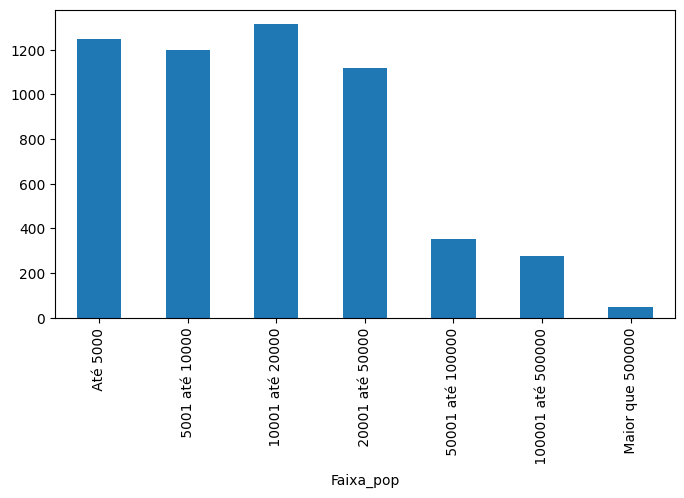

In [20]:
df.groupby("Faixa_pop", observed=False)['UF'].count().plot(kind='bar', figsize=(8,4))

In [21]:
df1 = df.copy()
df1 = df1.drop(columns=['UF', 'Mun', 'Idade'])
colunas = df1.columns
colunas

Index(['Faixa_pop', 'Regiao', 'Reeleito', 'Sexo', 'Cor', 'Escolaridade'], dtype='object')

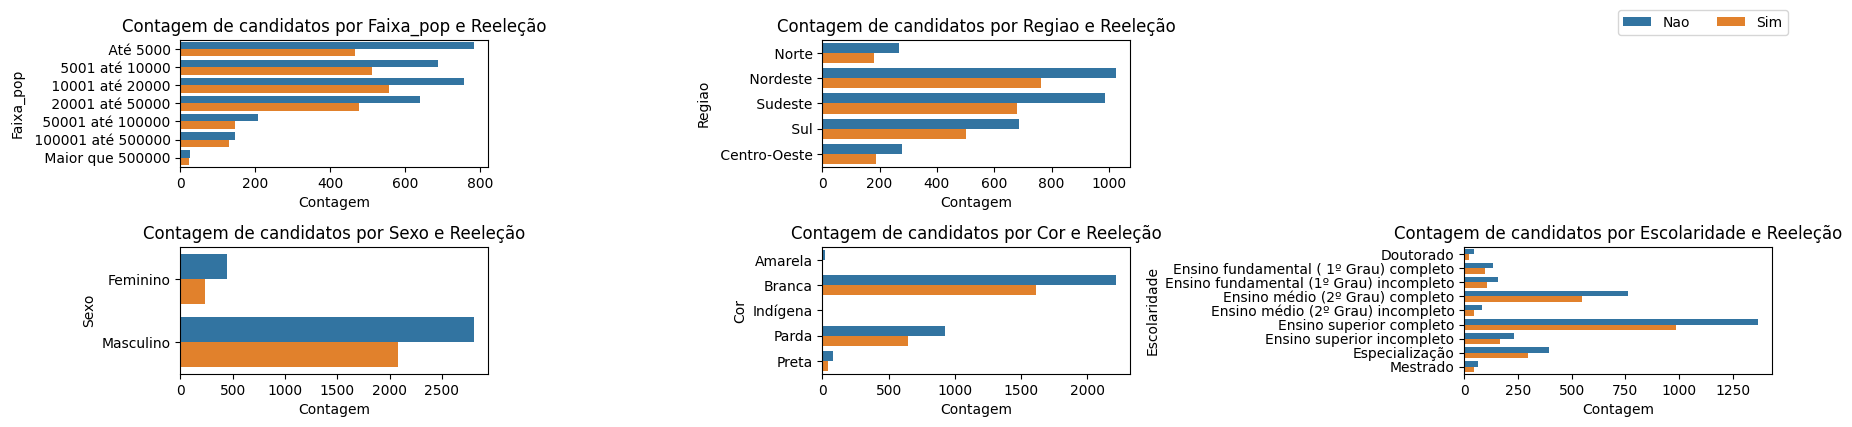

In [22]:
plt.figure(figsize=(18,8))
for i, col in enumerate(colunas, 1):
    if col == 'Reeleito':
        continue
    plt.subplot(4,3,i)
    agrupado = df1.groupby([col, "Reeleito"], observed=False).size().reset_index(name="Contagem")
    sns.barplot(y = col, x = 'Contagem', hue='Reeleito', data=agrupado, orient='h')
    plt.title(f'Contagem de candidatos por {col} e Reeleção')
    plt.ylabel(col)
    plt.xlabel('Contagem')
    plt.legend().remove()
    if i == len(colunas) - 1:
        handles, labels = plt.gca().get_legend_handles_labels()
plt.tight_layout()
plt.figlegend(handles, labels, loc='upper right', ncol=2, bbox_to_anchor=(1, 1))
plt.show()

In [23]:
agrupado = df.groupby(["Regiao", "Cor"], observed=False).size().reset_index(name="Contagem")
agrupado

,Regiao,Cor,Contagem
0,Norte,Amarela,0
1,Norte,Branca,175
2,Norte,Indígena,3
3,Norte,Parda,258
4,Norte,Preta,11
5,Nordeste,Amarela,7
6,Nordeste,Branca,877
7,Nordeste,Indígena,2
8,Nordeste,Parda,833
9,Nordeste,Preta,69


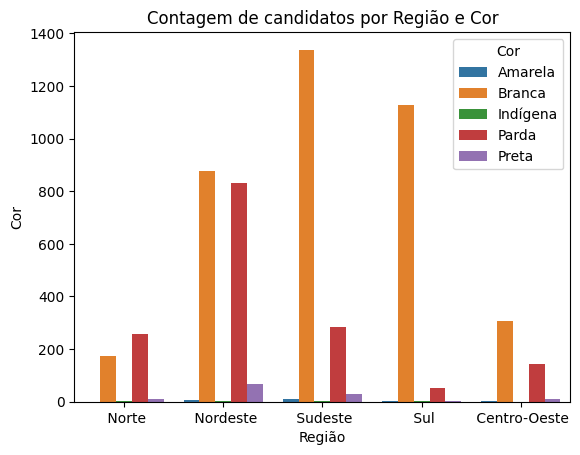

In [24]:
sns.barplot(x = 'Regiao', y = 'Contagem', hue='Cor', data=agrupado)
plt.title('Contagem de candidatos por Região e Cor')
plt.xlabel('Região')
plt.ylabel('Cor')

plt.show()

In [25]:
df["Idade"].describe()

count    5557.000000
mean       50.010077
std        10.867994
min        21.000000
25%        42.000000
50%        50.000000
75%        58.000000
max        95.000000
Name: Idade, dtype: float64

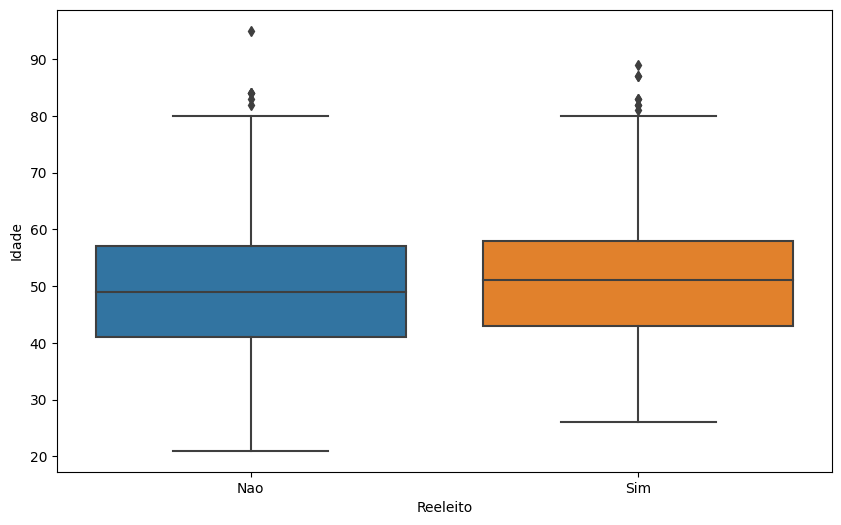

In [26]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Reeleito', y='Idade', data=df)
plt.show()

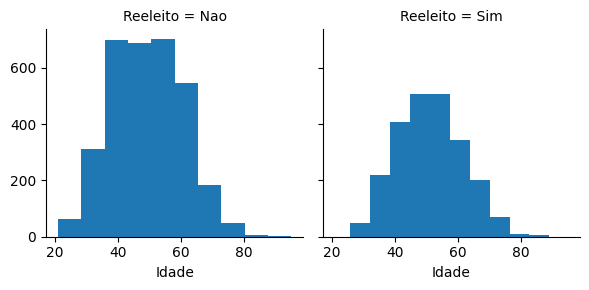

In [27]:
g = sns.FacetGrid(df, col='Reeleito')
g.map(plt.hist, 'Idade')
plt.show()

# Pre-processamento e escolha das váriaveis

In [28]:
df['Reeleito'] = df['Reeleito'].replace({'Sim': 1, 'Nao': 0})
df['Reeleito'] = df['Reeleito'].astype('bool')
df

,UF,Mun,Faixa_pop,Regiao,Reeleito,Sexo,Idade,Cor,Escolaridade
0,RO,Alta Floresta DOeste,20001 até 50000,Norte,False,Masculino,40,Branca,Especialização
1,RO,Ariquemes,100001 até 500000,Norte,False,Feminino,33,Branca,Ensino superior completo
2,RO,Cabixi,5001 até 10000,Norte,True,Masculino,50,Parda,Ensino superior completo
3,RO,Cacoal,50001 até 100000,Norte,False,Masculino,35,Parda,Ensino superior completo
4,RO,Cerejeiras,10001 até 20000,Norte,True,Feminino,57,Branca,Ensino superior completo
...,...,...,...,...,...,...,...,...,...
5565,GO,Vianópolis,10001 até 20000,Centro-Oeste,False,Masculino,38,Branca,Ensino superior completo
5566,GO,Vicentinópolis,5001 até 10000,Centro-Oeste,True,Masculino,55,Branca,Ensino médio (2º Grau) completo
5567,GO,Vila Boa,5001 até 10000,Centro-Oeste,False,Masculino,49,Branca,Ensino superior completo
5568,GO,Vila Propício,5001 até 10000,Centro-Oeste,False,Masculino,49,Parda,Ensino superior completo


Correlação entre as váriaveis independentes com a target váriavel usando o teste Chi-quadrado para as categóricas e t-student para a númerica.

In [29]:
categorical_vars = ['UF', 'Mun', 'Faixa_pop', 'Regiao', 'Sexo', 'Cor', 'Escolaridade']

for var in categorical_vars:
    tabela = pd.crosstab(df[var], df['Reeleito'])
    chi2, p, dof, expected = chi2_contingency(tabela)
    print(f"{var}: p-valor = {p:.5f}")

UF: p-valor = 0.31469
Mun: p-valor = 0.40540
Faixa_pop: p-valor = 0.01750
Regiao: p-valor = 0.65197
Sexo: p-valor = 0.00007
Cor: p-valor = 0.19880
Escolaridade: p-valor = 0.60785


In [30]:
numeric_vars = ['Idade']

for var in numeric_vars:
    grupo_0 = df[df['Reeleito'] == 0][var]
    grupo_1 = df[df['Reeleito'] == 1][var]
    t_stat, p_valor = ttest_ind(grupo_0, grupo_1, nan_policy='omit')
    print(f"{var}: p-valor = {p_valor:.5f}")

Idade: p-valor = 0.00000


In [31]:
y = df['Reeleito']
X = pd.get_dummies(df.drop(columns=['Reeleito', 'Mun', 'UF'], axis=1))

In [32]:
smotenc=SMOTE() 
X,y=smotenc.fit_resample(X,y)
y.value_counts()

Reeleito
False    3245
True     3245
Name: count, dtype: int64

# Modelo com Rede Neural Feedforward

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

In [35]:
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)), 
    layers.Dense(128, activation='relu'), 
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  
])


model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

In [36]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=early_stopping,
    verbose=1
)

Epoch 1/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5039 - auc: 0.5004 - loss: 0.7466 - precision: 0.4989 - recall: 0.5185 - val_accuracy: 0.4904 - val_auc: 0.5727 - val_loss: 0.7006 - val_precision: 1.0000 - val_recall: 0.0038
Epoch 2/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5188 - auc: 0.5437 - loss: 0.6979 - precision: 0.5180 - recall: 0.5401 - val_accuracy: 0.4885 - val_auc: 0.5699 - val_loss: 0.7592 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5314 - auc: 0.5465 - loss: 0.7050 - precision: 0.5343 - recall: 0.5014 - val_accuracy: 0.5827 - val_auc: 0.6139 - val_loss: 0.6779 - val_precision: 0.5558 - val_recall: 0.9173
Epoch 4/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5446 - auc: 0.5571 - loss: 0.6958 - precision: 0.5458 - recall: 0.4992 - val_accuracy: 0.5538 - val_auc: 0.6206 - val_loss: 0.6925 - val_precision: 0.5353 - val_recall: 0.9699
Epoch 5/100
146/146 

Acurácia: 0.5940
Precisão: 0.5858
Recall: 0.6248
AUC: 0.6506
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


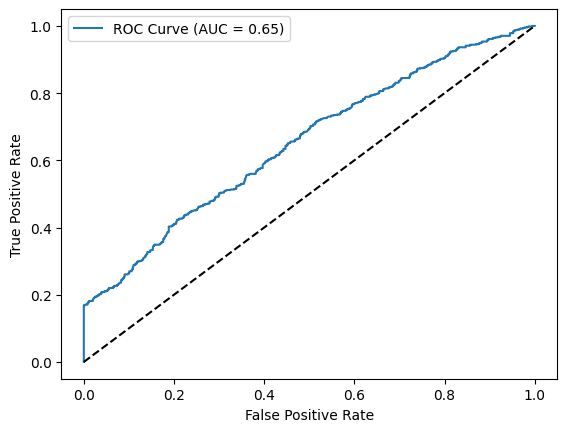

array([0.5299221 , 0.43061072, 0.41882628, ..., 0.38504288, 0.46780166,
       0.2731377 ], dtype=float32)

In [37]:
results = model.evaluate(X_test, y_test, verbose=0)
print(f"Acurácia: {results[1]:.4f}")
print(f"Precisão: {results[2]:.4f}")
print(f"Recall: {results[3]:.4f}")
print(f"AUC: {results[4]:.4f}")

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_pred_proba = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % roc_auc_score(y_test, y_pred_proba))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
y_pred_proba

# Tentativa com outros modelos

In [38]:
modelos = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', random_state=42),
    'RBF Neural Network': MLPClassifier(hidden_layer_sizes=(50,), activation='tanh', solver='adam', max_iter=500, random_state=42),
    'BP Neural Network': MLPClassifier(hidden_layer_sizes=(50,), activation='relu', solver='adam', max_iter=500, random_state=42)
}

In [39]:
desempenho = {}
for nome, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    desempenho[nome] = acc
    print(f'\nModelo: {nome}')
    print(f'Acurácia: {acc:.4f}')
    print(classification_report(y_test, y_pred))


Modelo: Random Forest
Acurácia: 0.5878
              precision    recall  f1-score   support

         0.0       0.59      0.58      0.59       653
         1.0       0.58      0.59      0.59       645

    accuracy                           0.59      1298
   macro avg       0.59      0.59      0.59      1298
weighted avg       0.59      0.59      0.59      1298


Modelo: SVM
Acurácia: 0.5354
              precision    recall  f1-score   support

         0.0       0.57      0.30      0.39       653
         1.0       0.52      0.77      0.62       645

    accuracy                           0.54      1298
   macro avg       0.55      0.54      0.51      1298
weighted avg       0.55      0.54      0.51      1298


Modelo: RBF Neural Network
Acurácia: 0.6063
              precision    recall  f1-score   support

         0.0       0.60      0.63      0.62       653
         1.0       0.61      0.58      0.60       645

    accuracy                           0.61      1298
   macro avg 

In [40]:
train_data = lgb.Dataset(X_train, label=y_train)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

model = lgb.train(params, train_data, num_boost_round=100)

[LightGBM] [Info] Number of positive: 2600, number of negative: 2592
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 116
[LightGBM] [Info] Number of data points in the train set: 5192, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500770 -> initscore=0.003082
[LightGBM] [Info] Start training from score 0.003082


In [41]:
y_pred = model.predict(X_test)
y_pred = [1 if p > 0.5 else 0 for p in y_pred]  
from sklearn.metrics import accuracy_score
print("Acurácia:", accuracy_score(y_test, y_pred))

Acurácia: 0.6163328197226502
